Implementing Neural Networks

The following jupyter notebook implements 4 different BERT models in conjunction with the SciKit-Learn Random Forest classifier. These BERT transformer models are 'roberta-base', 'roberta-large', 'distilroberta-base'.

In [1]:
## Importing all relevant libraries

import random

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

from transformers import pipeline
from transformers import AutoTokenizer, AutoModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier


import torch

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from transformers import BartModel, BartConfig
from transformers import BigBirdModel, BigBirdConfig


In [2]:
## Setting a random seed, this will be the seed for all our random_state seeds
random.seed(65432)

In [3]:
df = pd.read_excel(r"Data_600_Labeled_Final copy.xlsx", index_col=0) ## Reading in data
df_save = df.reset_index(inplace=False, drop = True)
df = df[['full_text', 'YN_INNOVATION']].reset_index(inplace=False, drop = True)

In [4]:
## Balancing target class 

df_yes = df[df.YN_INNOVATION == 'yes']
df_no = df[df.YN_INNOVATION == 'no']

if len(df_yes) == len(df_no):
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_yes) > len(df_no):
    df_yes = df_yes.sample(n=len(df_no), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_no) > len(df_yes):
    df_no = df_no.sample(n=len(df_yes), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
df = df.sample(n=len(df), random_state = 65432).reset_index(inplace=False, drop = True)

    
print("Value counts for target variable:\n",df.YN_INNOVATION.value_counts())

## Encoding target variable

le = preprocessing.LabelEncoder()
df.YN_INNOVATION = le.fit_transform(df.YN_INNOVATION)
print("\n\n\nThe target variable classes are:", le.classes_)

Value counts for target variable:
 no     222
yes    222
Name: YN_INNOVATION, dtype: int64



The target variable classes are: ['no' 'yes']


In [5]:
## NLP Models from Hugging Face, pretrained_weights object is changed according to required model
model_class, tokenizer_class, pretrained_weights = (AutoModel, 
                                                    AutoTokenizer, ['google/bigbird-roberta-base', 'google/bigbird-roberta-large'])

In [6]:

features_dict = {} ## Empty dict to store features


for weights in pretrained_weights:
    # Load pretrained model/tokenizer
    
    tokenizer = tokenizer_class.from_pretrained(weights)
    
    model = model_class.from_pretrained(weights)
    
    ## Tokenization
    tokenized = df['full_text'].apply((lambda x: tokenizer.encode(x,
                                                                  add_special_tokens=True, 
                                                                  truncation=True,
                                                                  max_length=512)))
    ## Padding
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    
    ## Attention Mask
    attention_mask = np.where(padded != 0, 1, 0)
    
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    ## Features
    features = last_hidden_states[0][:,0,:].numpy()
    features_dict.update({weights:features})

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.b

In [7]:
labels = df.YN_INNOVATION ## Target variable

In [8]:
## Splitting th data into train and test sets of features and target
train_features_dict = {}
test_features_dict = {}
train_labels_dict = {}
test_labels_dict = {}

for weights, features in features_dict.items():
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 65432)
    train_features_dict.update({weights:train_features})
    test_features_dict.update({weights:test_features})
    train_labels_dict.update({weights:train_labels})
    test_labels_dict.update({weights:test_labels})

In [9]:
test_labels_predict_dict = {}
test_labels_predict_proba_dict = {}
solver_list = ['sgd', 'lbfgs', 'adam']
for key in features_dict.keys():
    for solver in solver_list:
        clf = MLPClassifier(solver=solver, alpha=1e-5, hidden_layer_sizes=(5, 5), random_state=65432, 
                            warm_start=True, max_iter=10000)
        clf.fit(train_features_dict[key],train_labels_dict[key])
        predicted_y = clf.predict(test_features_dict[key])
        pred_prob = clf.predict_proba(test_features_dict[key])[:, 1]
        test_labels_predict_dict.update({key+"_"+solver+"-solver":predicted_y})
        test_labels_predict_proba_dict.update({key+"_"+solver+"-solver":pred_prob})

        test_labels_predict_dict.update({key+"_"+solver+"-solver":predicted_y})
        test_labels_predict_proba_dict.update({key+"_"+solver+"-solver":pred_prob})


========= google/bigbird-roberta-base_sgd-solver model ==========

Accuracy of the of the google/bigbird-roberta-base_sgd-solver model is 87.39%.
Precision rate of the google/bigbird-roberta-base_sgd-solver model is 86.44%.
Recall rate of the google/bigbird-roberta-base_sgd-solver model is 89.47%.
F-1 score of the google/bigbird-roberta-base_sgd-solver model is 87.93%.

The confusion matrix for the google/bigbird-roberta-base_sgd-solver model is:


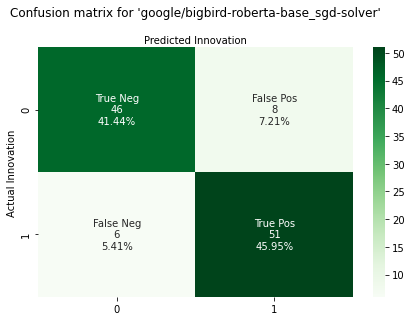

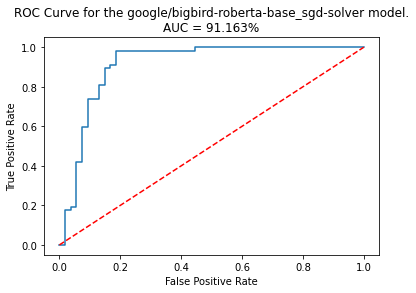


========= google/bigbird-roberta-base_lbfgs-solver model ==========

Accuracy of the of the google/bigbird-roberta-base_lbfgs-solver model is 81.98%.
Precision rate of the google/bigbird-roberta-base_lbfgs-solver model is 81.36%.
Recall rate of the google/bigbird-roberta-base_lbfgs-solver model is 84.21%.
F-1 score of the google/bigbird-roberta-base_lbfgs-solver model is 82.76%.

The confusion matrix for the google/bigbird-roberta-base_lbfgs-solver model is:


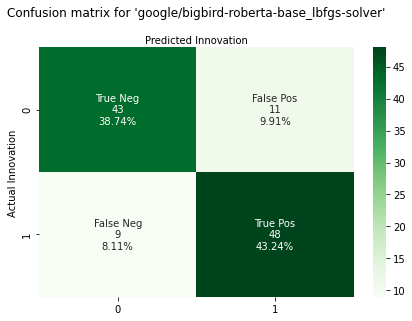

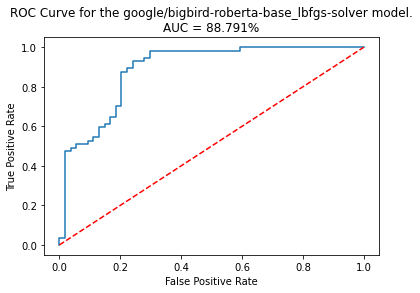


========= google/bigbird-roberta-base_adam-solver model ==========

Accuracy of the of the google/bigbird-roberta-base_adam-solver model is 83.78%.
Precision rate of the google/bigbird-roberta-base_adam-solver model is 81.97%.
Recall rate of the google/bigbird-roberta-base_adam-solver model is 87.72%.
F-1 score of the google/bigbird-roberta-base_adam-solver model is 84.75%.

The confusion matrix for the google/bigbird-roberta-base_adam-solver model is:


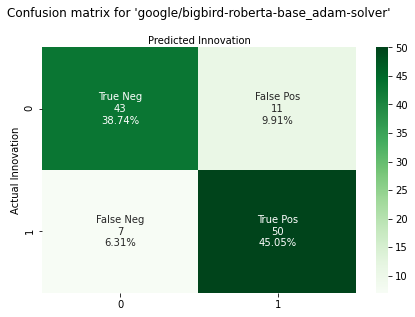

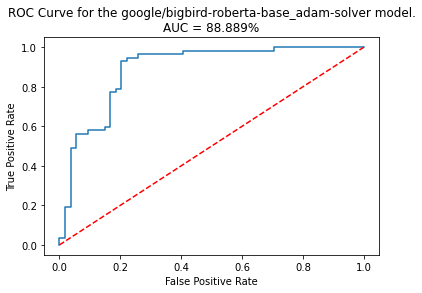


========= google/bigbird-roberta-large_sgd-solver model ==========

Accuracy of the of the google/bigbird-roberta-large_sgd-solver model is 82.88%.
Precision rate of the google/bigbird-roberta-large_sgd-solver model is 80.65%.
Recall rate of the google/bigbird-roberta-large_sgd-solver model is 87.72%.
F-1 score of the google/bigbird-roberta-large_sgd-solver model is 84.03%.

The confusion matrix for the google/bigbird-roberta-large_sgd-solver model is:


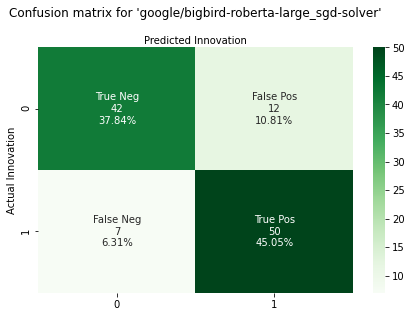

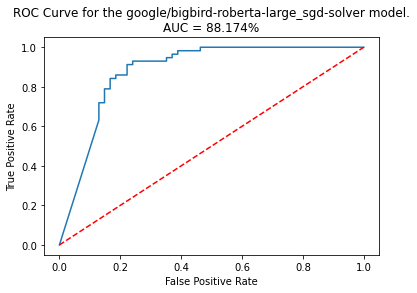


========= google/bigbird-roberta-large_lbfgs-solver model ==========

Accuracy of the of the google/bigbird-roberta-large_lbfgs-solver model is 80.18%.
Precision rate of the google/bigbird-roberta-large_lbfgs-solver model is 77.78%.
Recall rate of the google/bigbird-roberta-large_lbfgs-solver model is 85.96%.
F-1 score of the google/bigbird-roberta-large_lbfgs-solver model is 81.67%.

The confusion matrix for the google/bigbird-roberta-large_lbfgs-solver model is:


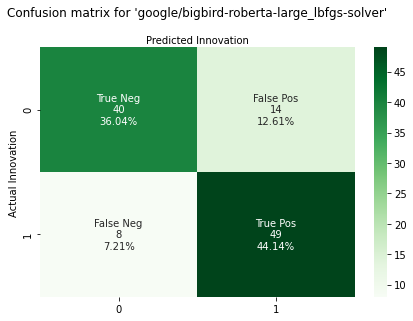

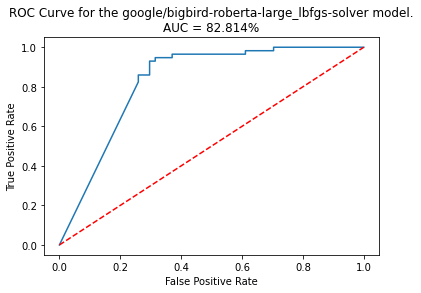


========= google/bigbird-roberta-large_adam-solver model ==========

Accuracy of the of the google/bigbird-roberta-large_adam-solver model is 81.98%.
Precision rate of the google/bigbird-roberta-large_adam-solver model is 83.64%.
Recall rate of the google/bigbird-roberta-large_adam-solver model is 80.7%.
F-1 score of the google/bigbird-roberta-large_adam-solver model is 82.14%.

The confusion matrix for the google/bigbird-roberta-large_adam-solver model is:


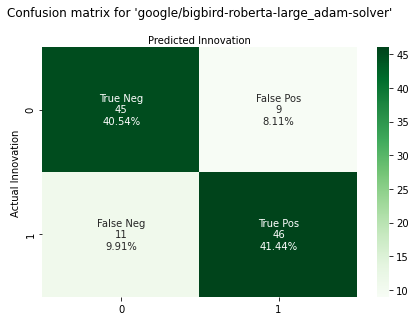

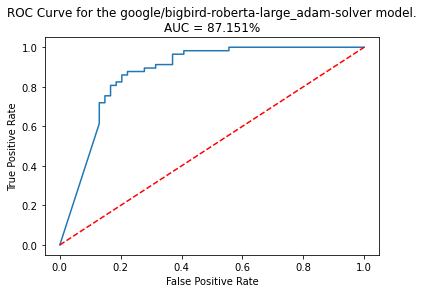

In [10]:
for key in test_labels_predict_dict.keys():
    print("\n=========",key, "model ==========\n")
    key0 = str.split(key, "_")[0]
    
    # Metrics
    accuracy = metrics.accuracy_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    precision=metrics.precision_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    recall=metrics.recall_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    f1_score = metrics.f1_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    
    print("Accuracy of the of the", key ,"model is {}%.".format(round((accuracy*100),2)))
    print("Precision rate of the", key, "model is {}%.".format(round((precision*100),2)))
    print("Recall rate of the", key, "model is {}%.".format(round((recall*100),2)))
    print("F-1 score of the", key, "model is {}%.".format(round((f1_score*100),2)))
    
    # Confusion Matrix
    print("\nThe confusion matrix for the", key,"model is:")
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]).flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]).flatten()/np.sum(metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(metrics.confusion_matrix(test_labels_dict[key0],y_pred=test_labels_predict_dict[key]), annot=labels, fmt='', cmap='Greens')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix for %r'%key, y=1.1)
    plt.ylabel('Actual Innovation')
    plt.xlabel('Predicted Innovation')
    plt.show()
    
    
    # ROC Graph
    fpr, tpr, thresholds = roc_curve(test_labels_dict[key0], test_labels_predict_proba_dict[key])
    auc = roc_auc_score(test_labels_dict[key0], test_labels_predict_proba_dict[key])

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', color="red")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for the "+key+" model.\nAUC = "+str(round(auc*100, 3))+"%")
    plt.show()

In [11]:
metrics_dict = {}

for key in test_labels_predict_dict.keys():
    key0 = str.split(key, "_")[0]
    accuracy = metrics.accuracy_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    precision=metrics.precision_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    recall=metrics.recall_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    f1_score = metrics.f1_score(test_labels_dict[key0],y_pred=test_labels_predict_dict[key])
    auc = roc_auc_score(test_labels_dict[key0], test_labels_predict_proba_dict[key])
    
    true_neg = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[0][0]
    false_pos = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[0][1]
    false_neg = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[1][0]
    true_pos = metrics.confusion_matrix(test_labels_dict[key0], test_labels_predict_dict[key])[1][1]
    
    metrics_dict.update({key:{"accuracy": accuracy, 
                              "precision": precision, 
                              "recall": recall, 
                              "f1_score": f1_score, 
                              "auc": auc,
                              "true_positive": true_pos,
                              "true_negative": true_neg, 
                              "false_positive": false_pos,
                              "false_negative": false_neg}})

In [12]:
pd.DataFrame(metrics_dict).T

,accuracy,precision,recall,f1_score,auc,true_positive,true_negative,false_positive,false_negative
google/bigbird-roberta-base_sgd-solver,0.873874,0.864407,0.894737,0.879310,0.911631,51.0,46.0,8.0,6.0
google/bigbird-roberta-base_lbfgs-solver,0.819820,0.813559,0.842105,0.827586,0.887914,48.0,43.0,11.0,9.0
google/bigbird-roberta-base_adam-solver,0.837838,0.819672,0.877193,0.847458,0.888889,50.0,43.0,11.0,7.0
google/bigbird-roberta-large_sgd-solver,0.828829,0.806452,0.877193,0.840336,0.881741,50.0,42.0,12.0,7.0
google/bigbird-roberta-large_lbfgs-solver,0.801802,0.777778,0.859649,0.816667,0.828135,49.0,40.0,14.0,8.0
google/bigbird-roberta-large_adam-solver,0.819820,0.836364,0.807018,0.821429,0.871507,46.0,45.0,9.0,11.0


In [13]:
## Saving NN Model metrics to DataFrame
pd.DataFrame(metrics_dict).T.to_csv("NN_model_metrics_BigBird_Solvers.csv")